In [6]:
import time
import requests
import numpy as np
import pandas as pd
from scrapy.http import TextResponse
import re
import scrapy
from scrapy.crawler import CrawlerProcess
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import tensorflow as tf
import tensorflow_hub as hub
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from lightgbm import LGBMRegressor

# Scraping

In [ ]:
stack = 'https://stackoverflow.com/questions?tab=frequent&page=1'

In [ ]:
def get_response(URL: str):
    """
    This function takes URL as an input and provides response:
    - none is status code is not 200
    - scrapy TextResponse object otherwise
    """
    page = requests.get(URL)
    if page.status_code == 200:
        response = TextResponse(body=page.text,url=page.url,encoding="utf-8")
    else:
        response = None
        print("wrong status code")
    return response

In [ ]:
response = get_response(URL=stack)

In [ ]:
def stackscraper(URL = "https://stackoverflow.com/questions?tab=frequent&page=1"):
    question = response.css("h3 > a.question-hyperlink::text").extract()
    votes = response.css("span.vote-count-post strong::text").extract()
    answers = response.css("div >strong::text").extract()
    div_tags = response.css('div.tags')
    tags =[i.css("a::text").extract_first() for i in div_tags]
    views = response.css('div.statscontainer >div ~div::text').re('\d*\.?\d\w')
    urls = response.css('h3 > a.question-hyperlink::attr(href)').extract()
    base_url = 'https://stackoverflow.com'
    url = [base_url + i for i in urls]    
    data = {'question':question,'votes':votes,'answers':answers,'tags':tags,'views':views,'url':url,}
    df = pd.DataFrame(data)
    assert df.isna().sum().sum()==0
    return df

In [ ]:
df = []
for i in range(1,100):
    response = get_response(URL =(f'https://stackoverflow.com/questions?tab=frequent&page={i}'))
    df.append(stackscraper(response))

In [ ]:
df = pd.concat(df)

In [ ]:
#df.to_csv('simple_scrap.csv', index=False)

In [ ]:
class StackScraper(scrapy.Spider):
    name = "description_scraper"
    start_urls = df.url.tolist()
    allowed_domains = ["https://stackoverflow.com"]

    custom_settings = {
      "FEED_FORMAT":"json",
      "FEED_URI":"descriptions.json",
      "ROBOTSTXT_OBEY":True,
      'DOWNLOAD_DELAY':1,
      'RANDOMIZE_DOWNLOAD_DELAY':True,
  }

    def parse(self,response):
        """
        This function takes response and a single provides unicorn description
        """
        description = response.css('div.postcell > div.post-text > p ::text').extract()
        yield {"description":description,'url':response.url}

In [ ]:
process = CrawlerProcess()
process.crawl(StackScraper)
process.start()

# Analysis 

In [7]:
df = pd.read_csv('simple_scrap.csv').iloc[:, 1:]
descriptions = pd.read_json('descriptions.json')
descriptions['description'] = descriptions['description'].apply(lambda x: ' '.join(x))
data = df.merge(descriptions)
data['views']= data['views'].apply(lambda x: float(x[:-1])*1e6 if x[-1] == 'm' else float(x[:-1])*1e3)
data

,question,votes,answers,tags,views,url,description
0,"What is a NullPointerException, and how do I f...",209,12,java,2800000.0,https://stackoverflow.com/questions/218384/wha...,What are Null Pointer Exceptions ( java.lang.N...
1,How to make a great R reproducible example,2473,23,r,312000.0,https://stackoverflow.com/questions/5963269/ho...,"When discussing performance with colleagues, t..."
2,How do I return the response from an asynchron...,5591,39,javascript,1500000.0,https://stackoverflow.com/questions/14220321/h...,I have a function foo which makes an asynchr...
3,How can I prevent SQL injection in PHP?,2773,28,php,1800000.0,https://stackoverflow.com/questions/60174/how-...,If user input is inserted without modification...
4,RegEx match open tags except XHTML self-contai...,1511,35,html,2900000.0,https://stackoverflow.com/questions/1732348/re...,I need to match all of these opening tags: But...
...,...,...,...,...,...,...,...
4944,Generating random integer from a range,158,13,c++,272000.0,https://stackoverflow.com/questions/5008804/ge...,I need a function which would generate a rando...
4945,"In PHP, how do you change the key of an array ...",351,23,php,421000.0,https://stackoverflow.com/questions/240660/in-...,I have an associative array in the form key =...
4946,Convert XML to JSON (and back) using Javascript,145,11,javascript,367000.0,https://stackoverflow.com/questions/1773550/co...,How would you convert from XML to JSON and the...
4947,jQuery: find element by text,312,7,jquery,323000.0,https://stackoverflow.com/questions/7321896/jq...,Can anyone tell me if it's possible to find an...


In [8]:
url = 'https://www.tiobe.com/tiobe-index/'
tiobei = pd.read_html(url)[0],pd.read_html(url)[1]
tiobei = pd.concat(tiobei)
tiobei['Position'][20:]
tiobei["Jul 2020"][20:] = tiobei['Position'][20:]
ratings = tiobei[['Jul 2020','Programming Language']]
ratings['Jul 2020'] = ratings['Jul 2020'].astype(int)
ratings = ratings.reset_index().drop('index', axis = 1)
rate_dict = ratings.set_index('Programming Language').to_dict()['Jul 2020']
rate_dict
rate_dict = dict((k.lower(),v) for k,v in rate_dict.items())
data['tags'] = data['tags'].str.lower().map(rate_dict)

/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/gevorgatanesyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
data.dropna(inplace=True)
data

,question,votes,answers,tags,views,url,description
0,"What is a NullPointerException, and how do I f...",209,12,2.0,2800000.0,https://stackoverflow.com/questions/218384/wha...,What are Null Pointer Exceptions ( java.lang.N...
1,How to make a great R reproducible example,2473,23,8.0,312000.0,https://stackoverflow.com/questions/5963269/ho...,"When discussing performance with colleagues, t..."
2,How do I return the response from an asynchron...,5591,39,7.0,1500000.0,https://stackoverflow.com/questions/14220321/h...,I have a function foo which makes an asynchr...
3,How can I prevent SQL injection in PHP?,2773,28,9.0,1800000.0,https://stackoverflow.com/questions/60174/how-...,If user input is inserted without modification...
5,"What is a NullReferenceException, and how do I...",1874,28,5.0,1400000.0,https://stackoverflow.com/questions/4660142/wh...,"I have some code and when it executes, it thro..."
...,...,...,...,...,...,...,...
4941,How to Query an NTP Server using C#?,103,6,5.0,97000.0,https://stackoverflow.com/questions/1193955/ho...,All I need is a way to query an NTP Server usi...
4944,Generating random integer from a range,158,13,4.0,272000.0,https://stackoverflow.com/questions/5008804/ge...,I need a function which would generate a rando...
4945,"In PHP, how do you change the key of an array ...",351,23,9.0,421000.0,https://stackoverflow.com/questions/240660/in-...,I have an associative array in the form key =...
4946,Convert XML to JSON (and back) using Javascript,145,11,7.0,367000.0,https://stackoverflow.com/questions/1773550/co...,How would you convert from XML to JSON and the...


In [10]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x1a47474150>

In [11]:
def get_embeddings(df,model_mode=None):
    embeddings = [embed([desc]).numpy() for desc in df]
    
    return pd.DataFrame(np.concatenate(embeddings))


In [12]:
desc_embeddings = get_embeddings(data['description']) 
desc_embeddings

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.062535,0.005727,0.037514,-0.057664,-0.034622,0.004683,-0.050614,-0.017618,-0.030982,0.062940,...,-0.060128,-0.047388,0.042448,-0.023200,0.047575,0.047560,0.047950,0.059083,-0.044591,0.001286
1,-0.005991,-0.064379,0.034458,-0.059459,0.047258,-0.062054,0.005448,-0.024872,-0.063798,0.068812,...,0.015486,-0.071640,0.030445,-0.015672,0.005712,-0.023326,0.025560,0.075777,-0.060956,-0.039318
2,0.057889,-0.069428,-0.051225,-0.020196,-0.004315,-0.004172,0.003089,-0.055821,-0.047980,0.067588,...,0.005435,-0.070523,0.016034,-0.038148,0.056080,-0.014882,0.062356,0.070589,0.049682,0.045532
3,0.012304,-0.030564,0.053398,0.015097,-0.006520,0.038734,0.045082,0.027277,0.003904,0.073076,...,-0.051080,-0.076204,-0.013485,0.021108,0.049848,-0.026926,0.046495,0.072791,-0.033477,-0.014854
4,-0.018753,-0.025215,0.045206,-0.000561,-0.027438,0.047800,-0.075630,-0.013656,0.070450,0.074725,...,-0.047547,0.068549,0.053694,0.018883,0.022861,0.038380,-0.049091,0.067430,0.021086,0.019131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,-0.069570,-0.068271,-0.009041,0.050178,0.035407,-0.022200,-0.012869,0.036235,0.062430,0.057172,...,-0.041043,-0.023105,0.074384,-0.002221,0.067559,-0.017766,0.029880,0.074915,0.019333,0.000001
3358,-0.069740,-0.072688,0.015298,0.015147,0.057242,0.008763,-0.001441,-0.050060,-0.008186,0.019585,...,0.043036,-0.072678,0.032085,-0.061887,0.062504,-0.050479,-0.029082,0.072471,0.005543,-0.025833
3359,-0.027285,-0.074701,0.042825,0.001512,-0.010960,0.035588,-0.013213,-0.018034,0.039497,0.069272,...,0.013452,-0.074547,0.015082,-0.008622,0.056429,0.003328,-0.014376,0.073028,0.011499,0.002124
3360,0.024299,-0.056251,-0.048899,0.066498,0.034607,0.009954,0.016757,-0.023122,-0.043535,0.079935,...,-0.020874,0.016971,-0.010971,-0.035536,-0.054743,0.026897,-0.031874,0.082275,0.022983,-0.050769


In [13]:
lin = data[['votes','answers','tags','views']]

In [14]:
lin =lin.reset_index()
lin = lin.join(desc_embeddings)
lin.drop('index',axis =1)

,votes,answers,tags,views,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,209,12,2.0,2800000.0,0.062535,0.005727,0.037514,-0.057664,-0.034622,0.004683,...,-0.060128,-0.047388,0.042448,-0.023200,0.047575,0.047560,0.047950,0.059083,-0.044591,0.001286
1,2473,23,8.0,312000.0,-0.005991,-0.064379,0.034458,-0.059459,0.047258,-0.062054,...,0.015486,-0.071640,0.030445,-0.015672,0.005712,-0.023326,0.025560,0.075777,-0.060956,-0.039318
2,5591,39,7.0,1500000.0,0.057889,-0.069428,-0.051225,-0.020196,-0.004315,-0.004172,...,0.005435,-0.070523,0.016034,-0.038148,0.056080,-0.014882,0.062356,0.070589,0.049682,0.045532
3,2773,28,9.0,1800000.0,0.012304,-0.030564,0.053398,0.015097,-0.006520,0.038734,...,-0.051080,-0.076204,-0.013485,0.021108,0.049848,-0.026926,0.046495,0.072791,-0.033477,-0.014854
4,1874,28,5.0,1400000.0,-0.018753,-0.025215,0.045206,-0.000561,-0.027438,0.047800,...,-0.047547,0.068549,0.053694,0.018883,0.022861,0.038380,-0.049091,0.067430,0.021086,0.019131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,103,6,5.0,97000.0,-0.069570,-0.068271,-0.009041,0.050178,0.035407,-0.022200,...,-0.041043,-0.023105,0.074384,-0.002221,0.067559,-0.017766,0.029880,0.074915,0.019333,0.000001
3358,158,13,4.0,272000.0,-0.069740,-0.072688,0.015298,0.015147,0.057242,0.008763,...,0.043036,-0.072678,0.032085,-0.061887,0.062504,-0.050479,-0.029082,0.072471,0.005543,-0.025833
3359,351,23,9.0,421000.0,-0.027285,-0.074701,0.042825,0.001512,-0.010960,0.035588,...,0.013452,-0.074547,0.015082,-0.008622,0.056429,0.003328,-0.014376,0.073028,0.011499,0.002124
3360,145,11,7.0,367000.0,0.024299,-0.056251,-0.048899,0.066498,0.034607,0.009954,...,-0.020874,0.016971,-0.010971,-0.035536,-0.054743,0.026897,-0.031874,0.082275,0.022983,-0.050769


In [15]:
lin.columns = lin.columns.astype(str)
colnames = lin.columns.tolist()

In [16]:
lin.drop('index',axis = 1,inplace = True)

In [17]:
lin

,votes,answers,tags,views,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,209,12,2.0,2800000.0,0.062535,0.005727,0.037514,-0.057664,-0.034622,0.004683,...,-0.060128,-0.047388,0.042448,-0.023200,0.047575,0.047560,0.047950,0.059083,-0.044591,0.001286
1,2473,23,8.0,312000.0,-0.005991,-0.064379,0.034458,-0.059459,0.047258,-0.062054,...,0.015486,-0.071640,0.030445,-0.015672,0.005712,-0.023326,0.025560,0.075777,-0.060956,-0.039318
2,5591,39,7.0,1500000.0,0.057889,-0.069428,-0.051225,-0.020196,-0.004315,-0.004172,...,0.005435,-0.070523,0.016034,-0.038148,0.056080,-0.014882,0.062356,0.070589,0.049682,0.045532
3,2773,28,9.0,1800000.0,0.012304,-0.030564,0.053398,0.015097,-0.006520,0.038734,...,-0.051080,-0.076204,-0.013485,0.021108,0.049848,-0.026926,0.046495,0.072791,-0.033477,-0.014854
4,1874,28,5.0,1400000.0,-0.018753,-0.025215,0.045206,-0.000561,-0.027438,0.047800,...,-0.047547,0.068549,0.053694,0.018883,0.022861,0.038380,-0.049091,0.067430,0.021086,0.019131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,103,6,5.0,97000.0,-0.069570,-0.068271,-0.009041,0.050178,0.035407,-0.022200,...,-0.041043,-0.023105,0.074384,-0.002221,0.067559,-0.017766,0.029880,0.074915,0.019333,0.000001
3358,158,13,4.0,272000.0,-0.069740,-0.072688,0.015298,0.015147,0.057242,0.008763,...,0.043036,-0.072678,0.032085,-0.061887,0.062504,-0.050479,-0.029082,0.072471,0.005543,-0.025833
3359,351,23,9.0,421000.0,-0.027285,-0.074701,0.042825,0.001512,-0.010960,0.035588,...,0.013452,-0.074547,0.015082,-0.008622,0.056429,0.003328,-0.014376,0.073028,0.011499,0.002124
3360,145,11,7.0,367000.0,0.024299,-0.056251,-0.048899,0.066498,0.034607,0.009954,...,-0.020874,0.016971,-0.010971,-0.035536,-0.054743,0.026897,-0.031874,0.082275,0.022983,-0.050769


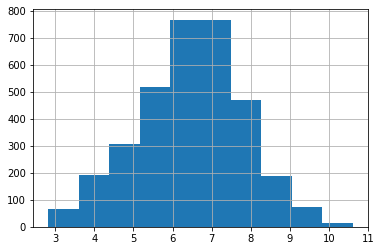

In [18]:
(lin['views'] ** 0.15).hist() 

In [22]:
X, y = lin.loc[:, lin.columns != 'views'], lin['views']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [24]:
model = sm.OLS(y_train ** 0.15, X_train).fit()

In [25]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  views   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              238.3
Date:                Sun, 02 Aug 2020   Prob (F-statistic):                        0.00
Time:                        23:45:30   Log-Likelihood:                         -2823.9
No. Observations:                2353   AIC:                                      6678.
Df Residuals:                    1838   BIC:                                      9646.
Df Model:                         515                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
votes          0.0006   2.82e-05     22.539      0.000       0.001       0.001
answers        0.0223      0.002     11.917      0.000       0.019       0.026
tags          -0.0071      0.006     -1.092      0.275      -0.020       0.006
0             -1.9623      2.094     -0.937      0.349      -6.069       2.145
1             -1.1212      1.474     -0.761      0.447      -4.012       1.770
2              1.8002      2.083      0.864      0.388      -2.285       5.886
3              1.3201      2.057      0.642      0.521      -2.714       5.354
4             -7.8791      2.254     -3.495      0.000     -12.300      -3.458
5             -0.0698      1.752     -0.040      0.968      -3.507       3.367
6             -0.4389      1.970     -0.223      0.824      -4.302       3.425
7              2.2256      2.168      1.027      0.305      -2.026       6.477
8             -2.1807      1.639     -1.330      0.184      -5.396       1.035
9              0.4965      1.750      0.284      0.777      -2.936       3.929
10             2.2965      2.320      0.990      0.322      -2.254       6.847
11            -1.7394      1.893     -0.919      0.358      -5.453       1.974
12            -0.1042      1.997     -0.052      0.958      -4.020       3.812
13             0.5390      1.566      0.344      0.731      -2.533       3.611
14             0.6778      1.916      0.354      0.724      -3.079       4.435
15            -0.9096      3.567     -0.255      0.799      -7.905       6.085
16             3.6990      2.303      1.606      0.108      -0.818       8.216
17            -0.2494      2.157     -0.116      0.908      -4.481       3.982
18             2.2844      2.031      1.125      0.261      -1.699       6.268
19             1.9029      1.954      0.974      0.330      -1.930       5.736
20             2.3715      1.911      1.241      0.215      -1.376       6.119
21            -1.2486      2.070     -0.603      0.546      -5.308       2.810
22             1.4164      2.022      0.701      0.484      -2.549       5.381
23            -1.9629      2.125     -0.924      0.356      -6.131       2.206
24             0.2921      2.105      0.139      0.890      -3.837       4.421
25            -2.5118      1.956     -1.284      0.199      -6.347       1.324
26             6.5310      2.069      3.156      0.002       2.473      10.589
27            -0.7579      2.103     -0.360      0.719      -4.882       3.366
28             2.6927      2.107      1.278      0.201      -1.439       6.825
29             1.6860      1.964      0.858      0.391      -2.166       5.539
30            -0.5642      2.117     -0.266      0.790      -4.717       3.588
31             0.5357      1.693      0.316      0.752      -

In [26]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred ** (1/0.15))

1170827.2188979597

In [27]:
lin.head()

,votes,answers,tags,views,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,209,12,2.0,2800000.0,0.062535,0.005727,0.037514,-0.057664,-0.034622,0.004683,...,-0.060128,-0.047388,0.042448,-0.023200,0.047575,0.047560,0.047950,0.059083,-0.044591,0.001286
1,2473,23,8.0,312000.0,-0.005991,-0.064379,0.034458,-0.059459,0.047258,-0.062054,...,0.015486,-0.071640,0.030445,-0.015672,0.005712,-0.023326,0.025560,0.075777,-0.060956,-0.039318
2,5591,39,7.0,1500000.0,0.057889,-0.069428,-0.051225,-0.020196,-0.004315,-0.004172,...,0.005435,-0.070523,0.016034,-0.038148,0.056080,-0.014882,0.062356,0.070589,0.049682,0.045532
3,2773,28,9.0,1800000.0,0.012304,-0.030564,0.053398,0.015097,-0.006520,0.038734,...,-0.051080,-0.076204,-0.013485,0.021108,0.049848,-0.026926,0.046495,0.072791,-0.033477,-0.014854
4,1874,28,5.0,1400000.0,-0.018753,-0.025215,0.045206,-0.000561,-0.027438,0.047800,...,-0.047547,0.068549,0.053694,0.018883,0.022861,0.038380,-0.049091,0.067430,0.021086,0.019131


In [28]:
model = LGBMRegressor(n_estimators=200, max_depth=7, n_jobs=-1)
model.fit(X_train, y_train ** 0.15)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [29]:
model.score(X_test, y_test ** 0.15)

0.7639152408609811

In [30]:
y_pred = model.predict(X_test)

In [31]:
mean_absolute_error(y_test, y_pred ** (1/0.15))

205905.82732470252

In [32]:
np.mean(np.abs((y_test - y_pred ** (1/0.15)) / y_test)) * 100

69.200679491029